In [1]:
%%capture
# move to src folder so we can import code
%cd ../src

In [2]:
import config
from common.kaggle import download_competition_data
from eda.plot import plot_count, pair_plot, plot_correlation_heatmap


In [3]:
download_competition_data(config.COMPETITION, config.INPUTS)


In this competition we will be using data generated by a deep learning model defined on the [Employee Attrition Dataset.](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset). We can expect the relationships between variables to be similar as in the original dataset, but not exactly the same.

We will be predicting whether an employee is likely to departure from its company based on the input parameters like education, job satisfaction, or performance. The following categorical independent features have been already encoded as values:

* Education
    1. 'Below College'
    1. 'College'
    1. 'Bachelor'
    1. 'Master'
    1. 'Doctor'
* EnvironmentSatisfaction
    1. 'Low'
    1. 'Medium'
    1. 'High'
    1. 'Very High'
* JobInvolvement
    1. 'Low'
    1. 'Medium'
    1. 'High'
    1. 'Very High'
* JobSatisfaction
    1. 'Low'
    1. 'Medium'
    1. 'High'
    1. 'Very High'
* PerformanceRating
    1. 'Low'
    1. 'Good'
    1. 'Excellent'
    1. 'Outstanding'
* RelationshipSatisfaction
    1. 'Low'
    1. 'Medium'
    1. 'High'
    1. 'Very High'
* WorkLifeBalance
    1. 'Bad'
    1. 'Good'
    1. 'Better'
    1. 'Best'

The evaluation metric is going to be AUC.


# Let's take a look at the data


In [4]:
from pathlib import Path
import pandas as pd


In [5]:
df = pd.read_csv(config.TRAIN_DATA)
df.head()


id  Age     BusinessTravel  DailyRate              Department  \
0   0   36  Travel_Frequently        599  Research & Development   
1   1   35      Travel_Rarely        921                   Sales   
2   2   32      Travel_Rarely        718                   Sales   
3   3   38      Travel_Rarely       1488  Research & Development   
4   4   50      Travel_Rarely       1017  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  \
0                24          3        Medical              1   
1                 8          3          Other              1   
2                26          3      Marketing              1   
3                 2          3        Medical              1   
4                 5          4        Medical              1   

   EnvironmentSatisfaction  ... StandardHours  StockOptionLevel  \
0                        4  ...            80                 1   
1                        1  ...            80                 1   
2                        3  ...            80                 2   
3                        3  ...            80                 0   
4                        2  ...            80                 0   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                 10                      2               3              10   
1                  4                      3               3               4   
2                  4                      3               3               3   
3                 15                      1               1               6   
4                 31                      0               3              31   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  Attrition  
0                  0                        7                     8          0  
1                  2                        0                     3          0  
2                  2                        1                     2          0  
3                  0                        0                     2          0  
4                 14                        4                    10          1  

[5 rows x 35 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1677 non-null   int64 
 1   Age                       1677 non-null   int64 
 2   BusinessTravel            1677 non-null   object
 3   DailyRate                 1677 non-null   int64 
 4   Department                1677 non-null   object
 5   DistanceFromHome          1677 non-null   int64 
 6   Education                 1677 non-null   int64 
 7   EducationField            1677 non-null   object
 8   EmployeeCount             1677 non-null   int64 
 9   EnvironmentSatisfaction   1677 non-null   int64 
 10  Gender                    1677 non-null   object
 11  HourlyRate                1677 non-null   int64 
 12  JobInvolvement            1677 non-null   int64 
 13  JobLevel                  1677 non-null   int64 
 14  JobRole                 

In [9]:
df.isnull().sum()

id                          0
Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithC

In [7]:
df.nunique()

id                          1677
Age                           43
BusinessTravel                 3
DailyRate                    625
Department                     3
DistanceFromHome              29
Education                      6
EducationField                 6
EmployeeCount                  1
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       6
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome                895
MonthlyRate                  903
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             41
TrainingTimesLastYear          7
WorkLifeBalance                4
YearsAtCom

In [8]:
len(df[df.duplicated()])

0

In [9]:
features = [f for f in df.columns if f not in ["id", config.TARGET]]
cat_features = df.select_dtypes("object").columns.to_list()
num_features = [f for f in features if f not in cat_features]

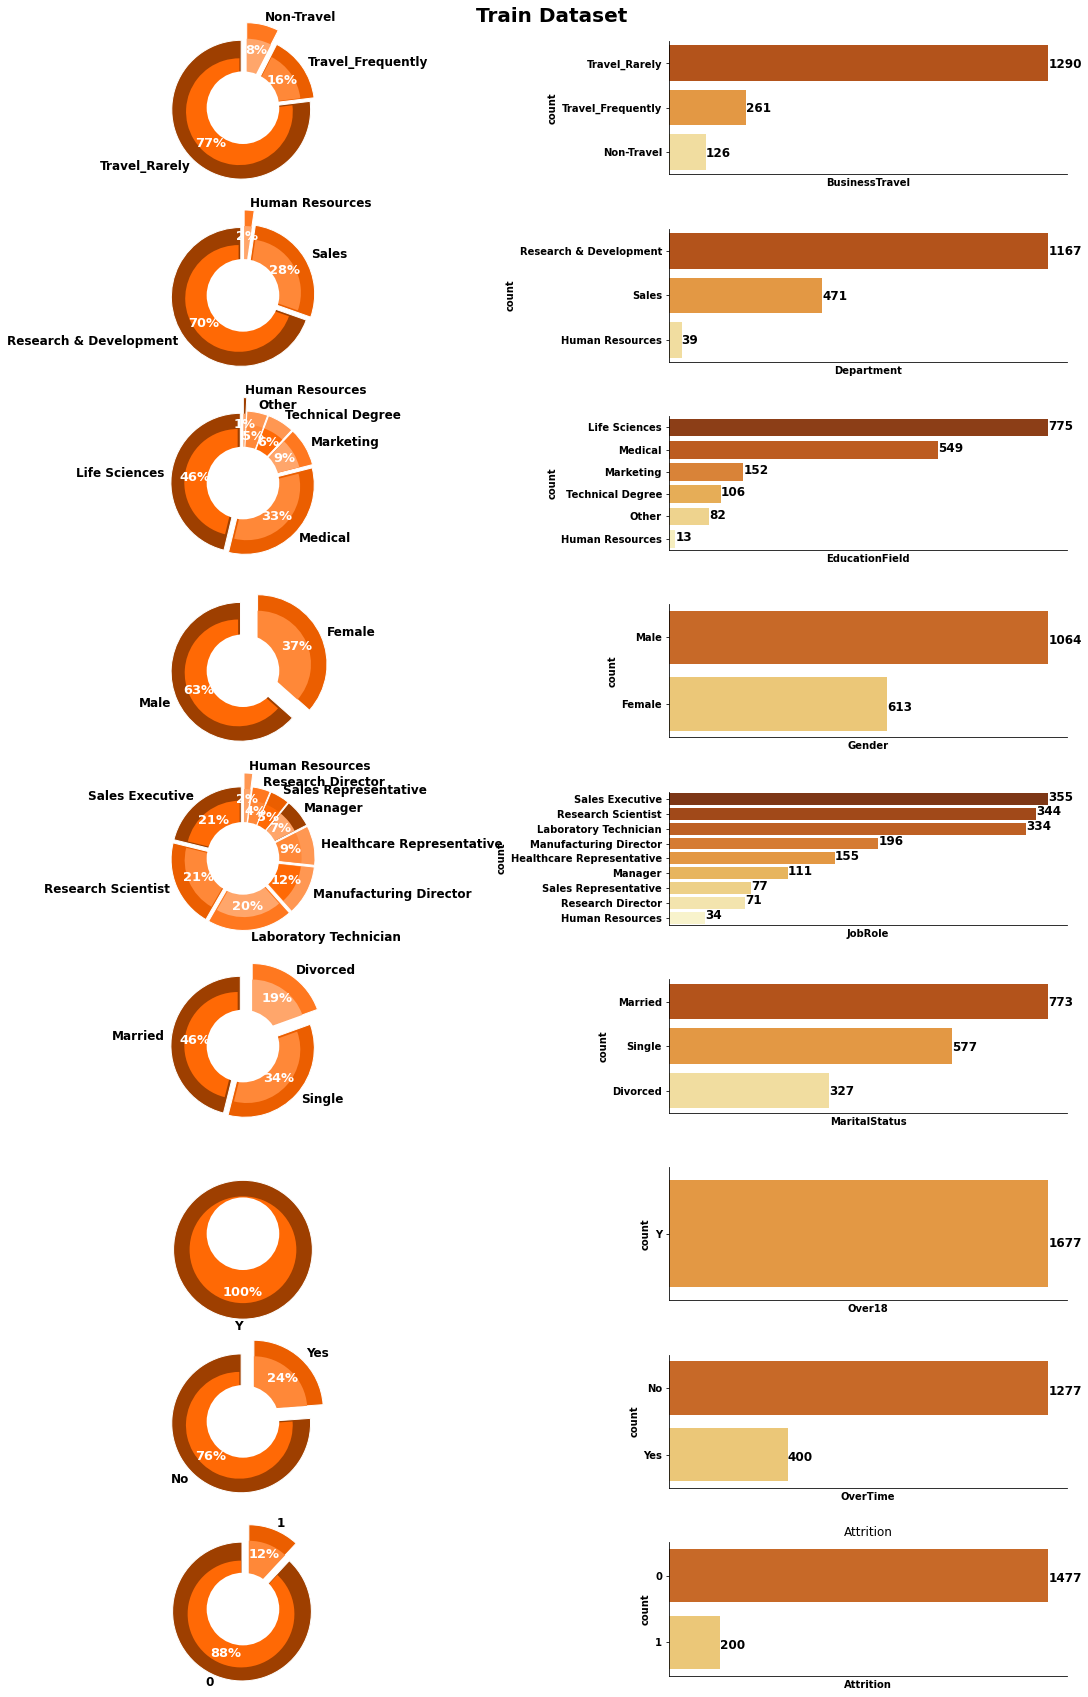

In [10]:
cat_and_target_features = cat_features.copy()
cat_and_target_features.append(config.TARGET)
plot_count(df, cat_and_target_features)


Initial observations:

- There are more males than females (63% vs 37%) in the dataset.
- Over18 can be removed as its value is static (all employees are above 18)
- Almost half (46%) of the employees are married, and the divorced represent a 19%.
- There is 12% of attrition in the dataset and 24% of overtime. That is interesting.\*

There is heavy target imbalance


In [11]:
df_test = pd.read_csv(config.TEST_DATA)

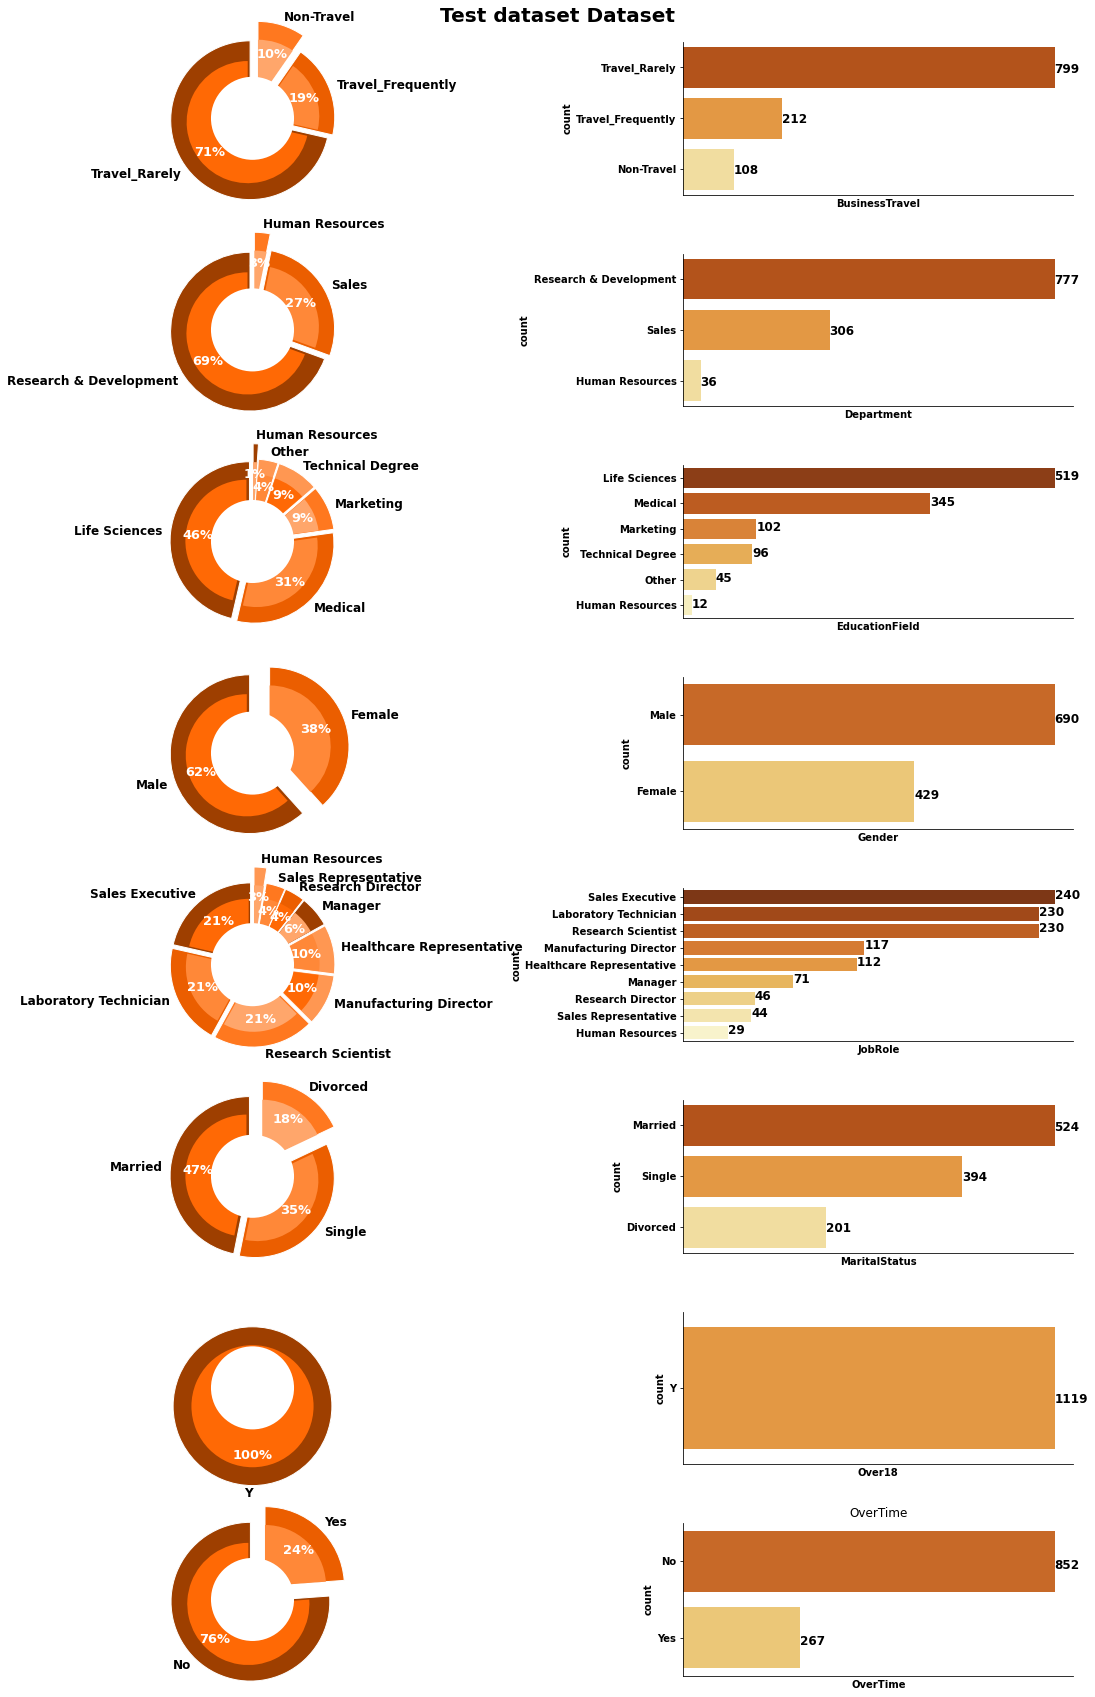

In [12]:
plot_count(df_test, cat_features, title_name="Test dataset")

In [13]:
df["is_train"] = 1
df_test["is_train"] = 0

# Remove id as it doesn't gives analysis value
df.drop(columns=["id", "Over18"], inplace=True)
df_test.drop(columns=["id", "Over18"], inplace=True)

combined_data = pd.concat(
    [
        df.drop(columns=config.TARGET),
        df_test,
    ]
).reset_index(drop=True)

df.drop(columns="is_train", inplace=True)
df_test.drop(columns="is_train", inplace=True)


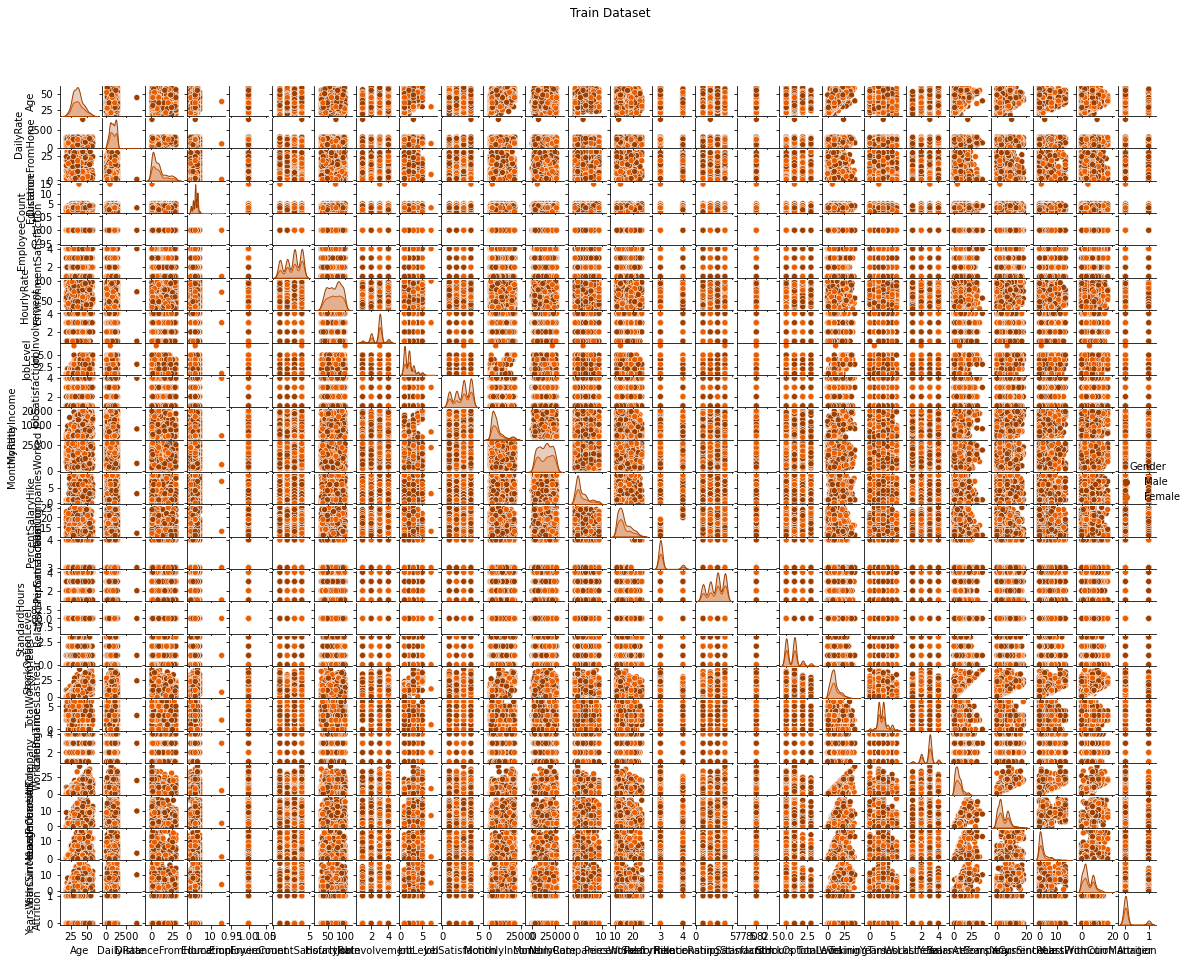

In [14]:
pair_plot(df, title_name="Train Dataset", hue="Gender")

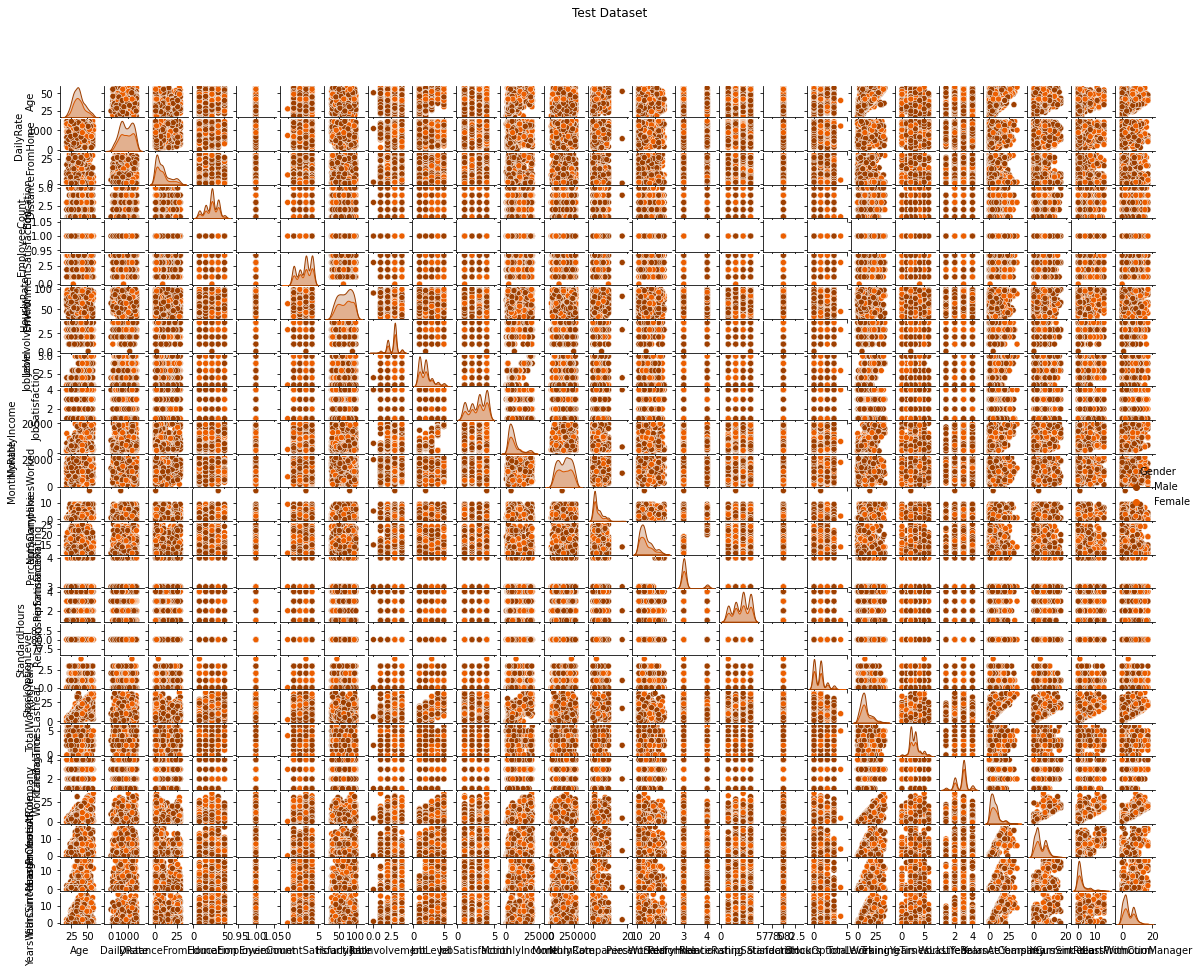

In [15]:
pair_plot(df_test, title_name="Test Dataset", hue="Gender")

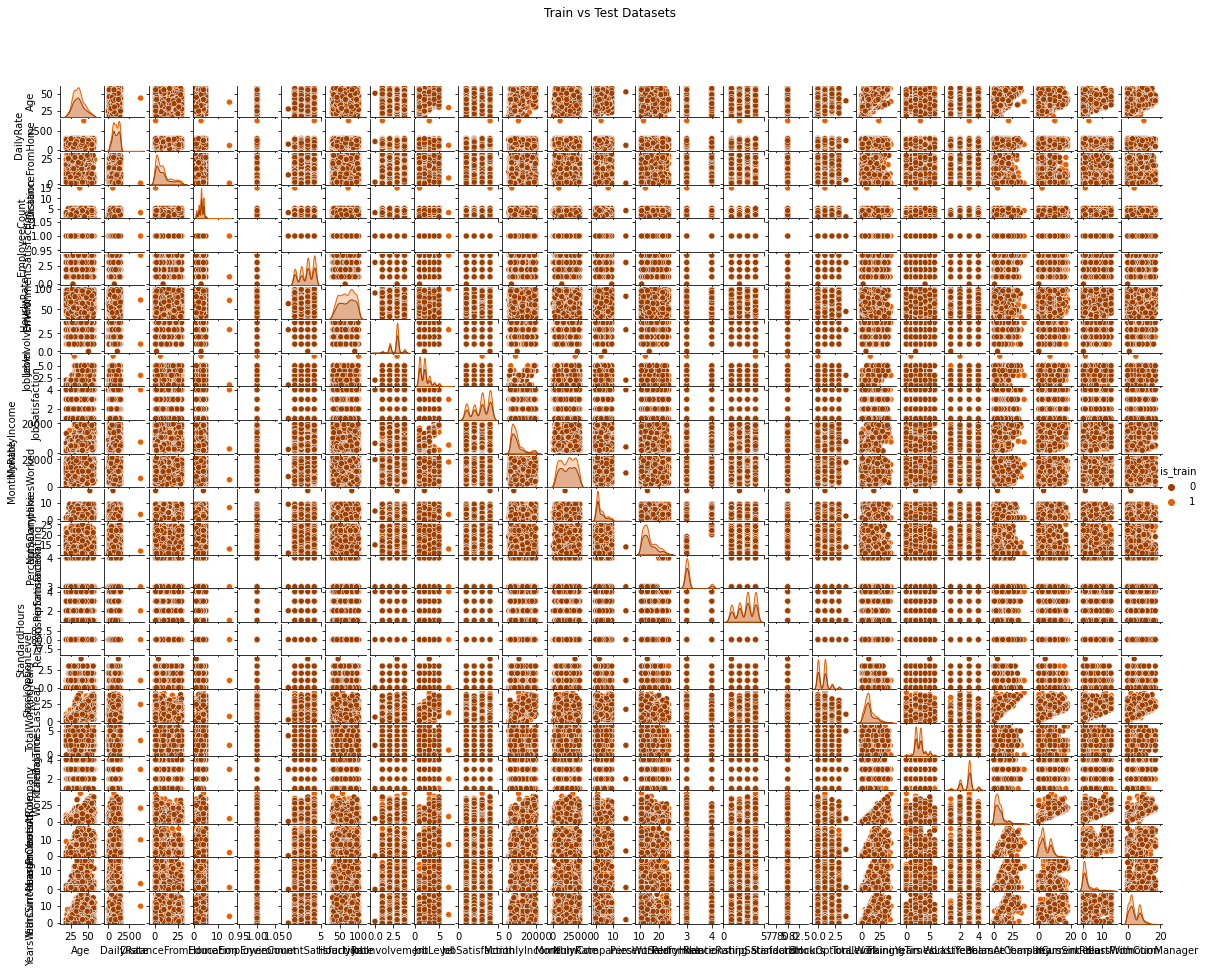

In [16]:
pair_plot(combined_data, title_name="Train vs Test Datasets", hue="is_train")

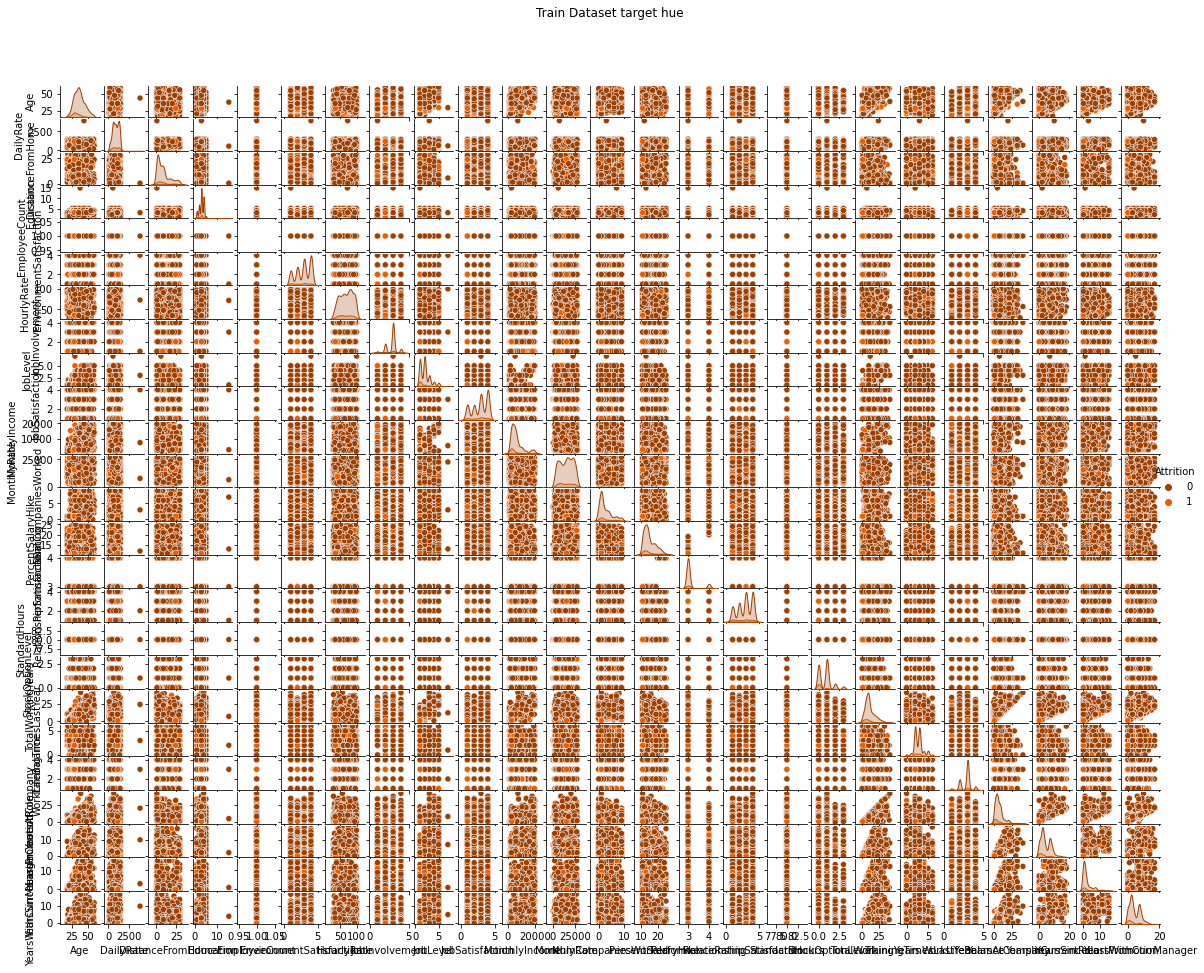

In [17]:
pair_plot(df, title_name="Train Dataset target hue", hue=config.TARGET)

Pairplots notes:

TODO: Maybe it is better to do some PCA or feature importance analysis before doing these plots

* Stroke becomes a major risk after ~age of 30. Older the person is higher the risk.
* bmi for stroke is between ~20-60 range. Google says Repeated studies estimate that each unit increase in body mass index (BMI) increases the risk of stroke by 5 percent.
* Strokes are more likely with high average glucose level.
* Test dataset follows train dataset distribution almost perfectily.

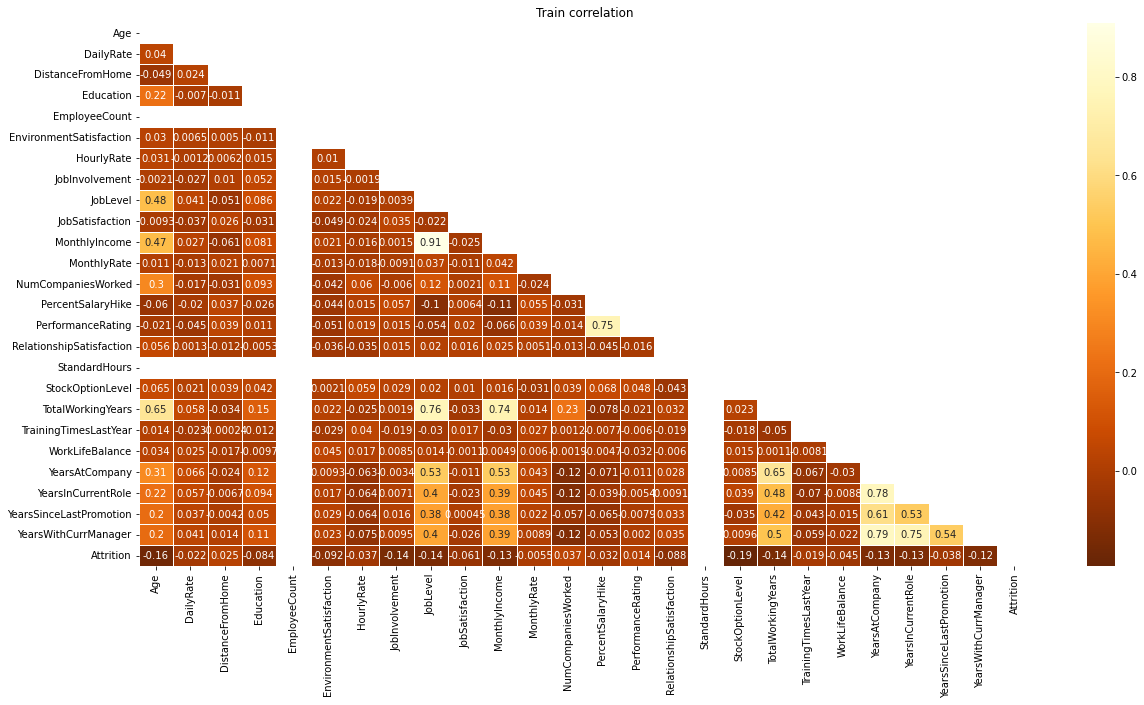

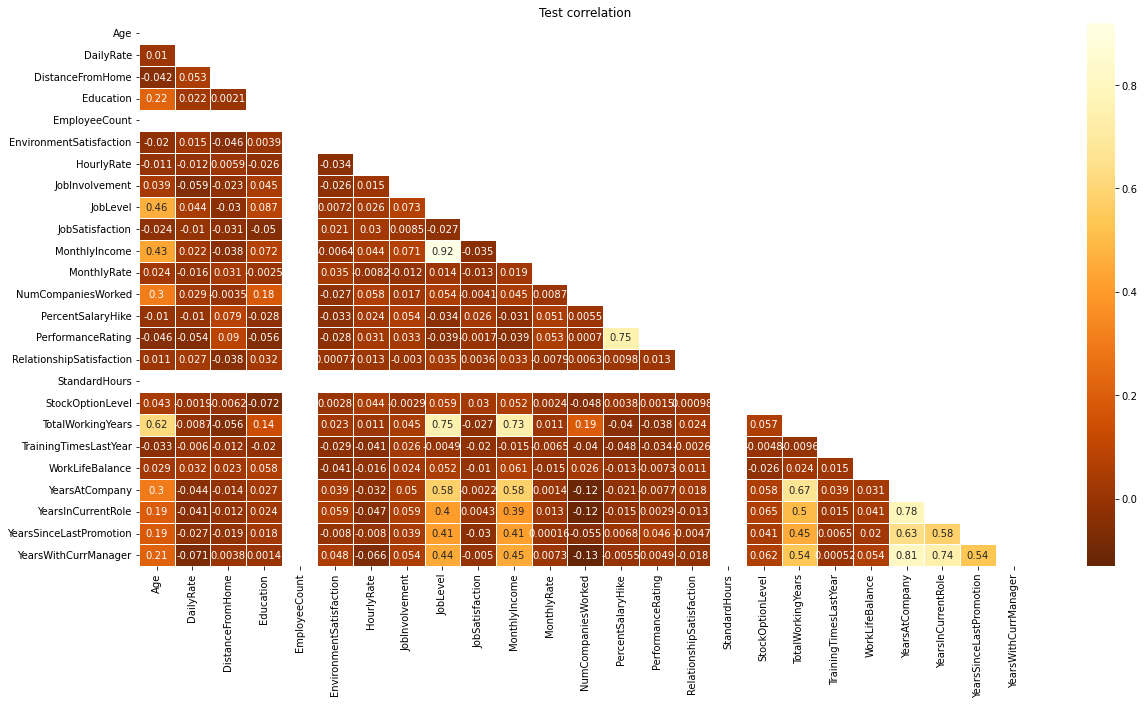

In [18]:
plot_correlation_heatmap(df)
plot_correlation_heatmap(df_test, 'Test correlation')

Correlation plot notes:

* There are some features highly correlated between them, maybe remove some would help.
* Target is not correlated with any single feature.